In [4]:
from pathlib import Path
import os
import requests
import zipfile

coco_path = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download")
train_path = coco_path / "train2017"
val_path= coco_path / "val2017"
annotations_path = coco_path / "annotations"

import random

import wandb


In [5]:

#wandb_key = "15e54d3617b01a5c40b75a944da46cfa8bfabb02"

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="harvardml",
    # Set the wandb project where this run will be logged.
    project="data-to-concept",
    # Track hyperparameters and run metadata.
    config={
        "dataset": "COCO",
    },
)

# Simulate training.
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset

    # Log metrics to wandb.
    run.log({"acc": acc, "loss": loss})

# Finish the run and upload any remaining data.
run.finish()

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
from pathlib import Path
from matplotlib import pyplot as plt

import numpy as np

def show_image_from_tensor(image_tensor):
    # 3 x 256 x 256
    image = image_tensor.numpy().transpose((1, 2, 0))
    image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

if False:
    class CocoDataset(Dataset):
        def __init__(self, image_dir, annotations_file=None, transform=None):
            self.image_dir = Path(image_dir)
            self.image_paths = sorted(self.image_dir.glob("*.jpg"))  # Load all JPGs
            self.transform = transform
            self.annotations = None
            
            if annotations_file:
                with open(annotations_file, "r") as f:
                    self.annotations = json.load(f)

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert("RGB")

            if self.transform:
                image = self.transform(image)

            # Return image only (modify if annotations are needed)
            return image

    # Instantiate datasets
    train_dataset = CocoDataset(train_path, transform=transform)
    val_dataset = CocoDataset(val_path, transform=transform)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Example batch
    sample_batch = next(iter(val_loader))
    print(sample_batch.shape)  # Should print [32, 3, 256, 256]

    print(sample_batch[0].shape)  # Should print [32, 3, 256, 256]


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from collections import Counter
v = [1,1,5,6,6,6,6,1,0]
v = [-1,2,1,0] 
Counter(v).most_common(1)[0][0]



-1

In [8]:
from collections import defaultdict

def get_image_num(image_path):
    # Extract the image number from the filename
    # Assuming filenames are like '000000000001.jpg'
    return int(image_path.stem)  # stem gives the filename without extension

class CocoDataset(Dataset):
    def __init__(self, image_dir, annotations_file=None, transform=None):
        self.image_dir = Path(image_dir)
        image_paths = sorted(self.image_dir.glob("*.jpg"))  # Load all JPGs
        self.transform = transform
        self.annotations_file = annotations_file
        if self.annotations_file is None:
            self.annotations_file = annotations_path / "instances_train2017.json"
        
        # load annotations
        with open(self.annotations_file, "r") as f:
            self.annotations_dict = json.load(f)

        categories = self.annotations_dict["categories"]
        
        # NOTE: there are gaps in the category IDs, e.g. category 12 is missing, so the labels are not contiguous, and need to be remapped
        self.label_to_category_id = {i: cat["id"] for i, cat in enumerate(categories)}
        self.label_to_category_name = {i: cat["name"] for i, cat in enumerate(categories)}
        self.category_id_to_label = {cat["id"]: i for i, cat in enumerate(categories)}
        self.image_ids = [ann["image_id"] for ann in self.annotations_dict["annotations"]]
        self.image_ids = sorted(list(set(self.image_ids)))
       
                              
        print(f"original len image_paths -- {len(image_paths)}")

        # Extract key data
        self.annotations = self.annotations_dict["annotations"]  # List of object 
        image_id_to_labels = defaultdict(list)  # Dictionary to map image IDs to categories
        self.categories = set()
        for ann in self.annotations:
            image_id = ann['image_id']
            category_id = ann['category_id']

            # map category_id to label_ind
            label = self.category_id_to_label[category_id]

            self.categories.add(label)
            image_id_to_labels[image_id].append(label)
            # sort image_id_to_category keys
        print(f"len image_id_to_category -- {len(image_id_to_labels)}")
    
        image_id_to_labels = dict(sorted(image_id_to_labels.items(), key=lambda item: item[0]))
        # missing image ids
        
        self.image_paths = [img_path for i, img_path in enumerate(image_paths) if get_image_num(img_path) in image_id_to_labels]
        # print the first 10
        for ii in range(1000):
            image_id = self.image_ids[ii]
            labels_ = image_id_to_labels.get(image_id, -1)
            if len(labels_) == 0:
                print(f"{ii} image_id {image_id} has {len(labels_)} annotations")

        # create labels for each image, which is the category of the most common annotation, tie breaking should be the first annotation (sorted)
        image_id_to_top_label = {}
        for k,v in image_id_to_labels.items():
            # get the most common category
            from collections import Counter
            most_common = Counter(v).most_common(1)
            # get the category id
            if len(most_common) == 0:
                print(f"Image ID {k} has no annotations.")
                raise
            top_label = most_common[0][0]
            image_id_to_top_label[k] = top_label
            if top_label >= 80:
                print(f"Image ID {k} has top label {top_label}.")   
        
        self.image_id_to_top_label = image_id_to_top_label
        self.image_id_to_labels = image_id_to_labels

        print(f"len image_id_to_top_label -- {len(self.image_id_to_top_label)}")
    def __len__(self):
        return len(self.image_paths)

    def get(self, idx, verbose = False):
        
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
    
        if verbose:
            print(f"idx = {idx}")
            print(f"image_path = {img_path}")
        if self.transform: 
            image = self.transform(image)
        image_id = get_image_num(img_path)
        top_label = self.image_id_to_top_label.get(image_id, -1)
        if verbose:
            print(f"image id {idx} has {self.image_id_to_top_label.get(idx, -1)} annotations ; top label - {top_label}")
            print(f"image_path = {img_path}")

        # Return image only (modify if annotations are needed)
        return image, top_label
    def __getitem__(self, idx):
        return self.get(idx)   

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for consistency
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Instantiate datasets
train_dataset = CocoDataset(train_path, transform=transform)
val_dataset = CocoDataset(val_path, transform=transform, annotations_file= annotations_path / "instances_val2017.json")



original len image_paths -- 118287
len image_id_to_category -- 117266
len image_id_to_top_label -- 117266
original len image_paths -- 5000
len image_id_to_category -- 4952
len image_id_to_top_label -- 4952


In [9]:
train_dataset.label_to_category_id
train_dataset.category_id_to_label
train_dataset.image_id_to_labels
for i in range(100):
    d, label_ = train_dataset[i]
    #print(f"image {i} has label {label_}")  
    if label_ == -1:
        d,label_ = train_dataset.get(i, verbose = True)
        print(f"label_ = {label_}")
        raise



In [10]:
if False:
    img_id = get_image_num(Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000250.jpg"))
    img_id
    train_dataset.image_id_to_labels[img_id]

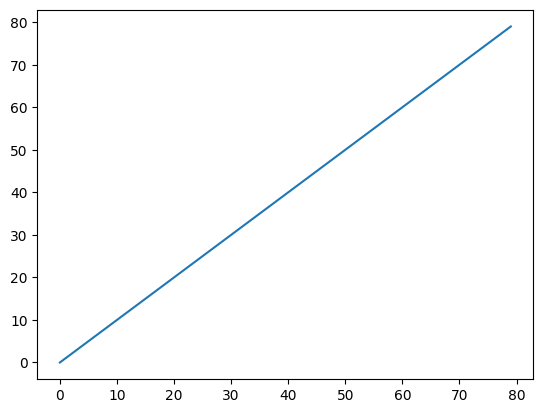

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [11]:
plt.plot(list(train_dataset.categories))
plt.show()
train_dataset.annotations_dict["categories"]
train_dataset.label_to_category_name

In [12]:
if False:
    class FilteredDataset(torch.utils.data.Dataset):
        def __init__(self, original_dataset):
            self.data = [(x, y) for x, y in original_dataset if y != -1]

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx]


    filtered_indices = [i for i, (_, label) in enumerate(train_dataset_) if label != -1]
    train_dataset_ = torch.utils.data.Subset(train_dataset_, filtered_indices)

    filtered_indices = [i for i, (_, label) in enumerate(val_dataset_) if label != -1]
    val_dataset_ = torch.utils.data.Subset(val_dataset_, filtered_indices)

    if False:
        train_dataset_ = FilteredDataset(train_dataset_)
        val_dataset_ = FilteredDataset(val_dataset_)
    print(f"len train_dataset_ -- {len(train_dataset_)}")
    print(f"len val_dataset_ -- {len(val_dataset_)}")

In [13]:
if False:
    valid_train_inds = [i for i,label in train_dataset_.image_id_to_top_label.items()  if label != -1]
    valid_val_inds = [i for i,label in val_dataset_.image_id_to_top_label.items()  if label != -1]

    print(len(valid_train_inds))
    print(len(valid_val_inds))
    train_dataset = torch.utils.data.Subset(train_dataset_, valid_train_inds)
    val_dataset = torch.utils.data.Subset(val_dataset_, valid_val_inds)

    #valid_val_inds = [i for i in val_dataset.image_id_to_top_label.keys() != None]
    #train_dataset = torch.utils.data.Subset(train_dataset, valid_train_inds)
    #val_dataset = torch.utils.data.Subset(val_dataset, valid_val_inds)


In [14]:
if False:
    valid_train_inds = [i for i,label in train_dataset.image_id_to_top_label.items()  if label != None]
    valid_val_inds = [i for i,label in val_dataset.image_id_to_top_label.items()  if label != None]

    #valid_val_inds = [i for i in val_dataset.image_id_to_top_label.keys() != None]
    train_dataset = torch.utils.data.Subset(train_dataset, valid_train_inds)
    val_dataset = torch.utils.data.Subset(val_dataset, valid_val_inds)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Example batch
sample_batch = next(iter(val_loader))
print(type(sample_batch))  # Should print [32, 3, 256, 256]

print(sample_batch[0].shape)  # Should print 

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<class 'list'>
torch.Size([32, 3, 256, 256])


In [15]:
print(sample_batch[1]) 

tensor([56, 21, 73, 11, 77,  0, 72,  0,  0,  0,  0,  0,  0, 48,  0, 64,  2,  0,
        15,  0, 22, 56,  0, 45,  0, 40,  0,  0, 41,  0,  0, 46])


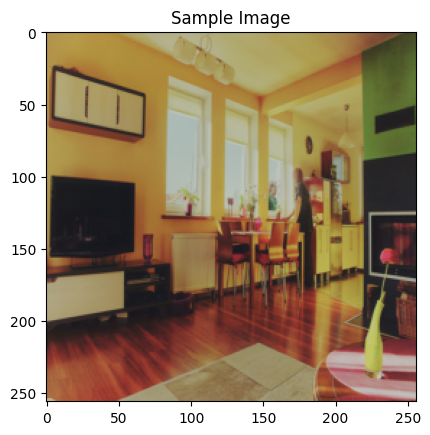

In [16]:
# show image
import matplotlib.pyplot as plt
import numpy as np
def imshow(tensor, title=None):
    image = tensor.numpy().transpose((1, 2, 0))
    image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

imshow(sample_batch[0][0], title="Sample Image")

# Extract some metadata about the image dataset

In [17]:
# list one annotation
import json
from pathlib import Path

if False:
    # Load COCO annotation file
    annotations_file = annotations_path / "instances_train2017.json"  # Change to val2017 if needed

    with open(annotations_file, "r") as f:
        coco_data = json.load(f)

coco_data = train_dataset.annotations_dict
# Extract key data
images = coco_data["images"]  # List of image metadata
annotations = coco_data["annotations"]  # List of object annotations
categories = coco_data["categories"]  # List of category mappings

category_id_to_name = {cat['id']: cat['name'] for cat in categories}
category_to_images = {}
# Create a mapping of category IDs to image IDs
for ann in annotations:
    category_id = ann['category_id']
    image_id = ann['image_id']
    if category_id not in category_to_images:
        category_to_images[category_id] = []
    category_to_images[category_id].append(image_id)


annotation_counts_per_image = {}
image_id_to_category = {}

for ann in annotations:
    image_id = ann['image_id']
    category_id = ann['category_id']
    if image_id not in annotation_counts_per_image:
        annotation_counts_per_image[image_id] = 0
    annotation_counts_per_image[image_id] += 1

    if image_id not in image_id_to_category:
        image_id_to_category[image_id] = []
    image_id_to_category[image_id].append(category_id)

# List the first 5 image metadata entries
print("First 5 Images Metadata:")
for img in images[:5]:
    print(f"ID: {img['id']}, File: {img['file_name']}, Size: {img['width']}x{img['height']}")

# List the first 5 annotations
print("\nFirst 5 Annotations:")
for ann in annotations[:5]:
    category = ann["category_id"]
    category_name = category_id_to_name.get(category, "Unknown")
    
    print(f"Image ID: {ann['image_id']}, Category: {ann['category_id']}, BBox: {ann['bbox']} -- {category_name}")


# List category mapping
print("\nCategories:")
for cat in categories:
    print(f"ID: {cat['id']}, Name: {cat['name']}")



First 5 Images Metadata:
ID: 391895, File: 000000391895.jpg, Size: 640x360
ID: 522418, File: 000000522418.jpg, Size: 640x480
ID: 184613, File: 000000184613.jpg, Size: 500x336
ID: 318219, File: 000000318219.jpg, Size: 556x640
ID: 554625, File: 000000554625.jpg, Size: 426x640

First 5 Annotations:
Image ID: 558840, Category: 58, BBox: [199.84, 200.46, 77.71, 70.88] -- hot dog
Image ID: 200365, Category: 58, BBox: [234.22, 317.11, 149.39, 38.55] -- hot dog
Image ID: 200365, Category: 58, BBox: [239.48, 347.87, 160.0, 57.81] -- hot dog
Image ID: 200365, Category: 58, BBox: [296.65, 388.33, 1.03, 0.0] -- hot dog
Image ID: 200365, Category: 58, BBox: [251.87, 333.42, 125.94, 22.71] -- hot dog

Categories:
ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
ID: 11, Name: fire hydrant
ID: 13, Name: stop sign
ID: 14, Name: parking meter
ID: 15,

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000558840.jpg


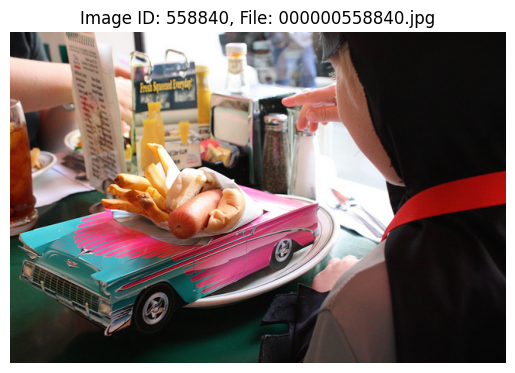

In [18]:
print(coco_data.keys())
# show image 558840
def show_image_from_id(image_id):
    # Find the image metadata
    image_info = next((img for img in coco_data["images"] if img["id"] == image_id), None)
    if not image_info:
        print(f"Image ID {image_id} not found.")
        return

    # Load the image
    img_path = train_path / image_info["file_name"]
    image = Image.open(img_path).convert("RGB")
    print(f"loading image path : {img_path}")
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image ID: {image_id}, File: {image_info['file_name']}")
    plt.show()
id_ = 558840
show_image_from_id(id_)

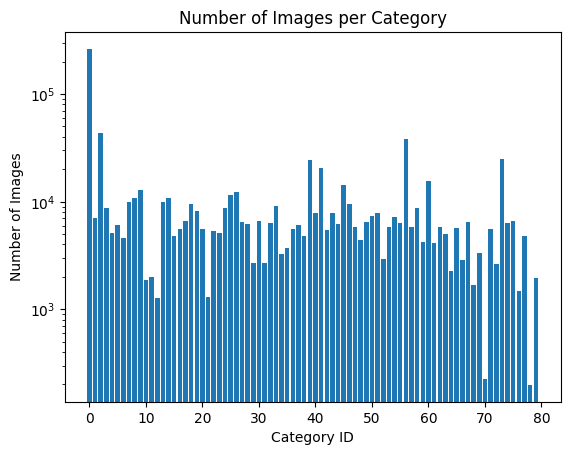

Top 3 Categories:
Category ID: 1, person : Count: 262465
Category ID: 3, car : Count: 43867
Category ID: 62, chair : Count: 38491

Bottom 3 Categories:
Category ID: 89, hair drier :  Count: 198
Category ID: 80, toaster :  Count: 225
Category ID: 14, parking meter :  Count: 1285


In [19]:
# sort category_to_images
category_to_images = dict(sorted(category_to_images.items()))

# plot hist of category_to_images counts
import matplotlib.pyplot as plt
counts = [len(image_ids) for image_ids in category_to_images.values()]
# plot bars
plt.bar(range(len(counts)), counts)
plt.xlabel('Category ID')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category')
plt.yscale('log')
plt.show()


# print top 3 and bottom 3 categories
top_3 = sorted(category_to_images.items(), key=lambda x: len(x[1]), reverse=True)[:3]
bottom_3 = sorted(category_to_images.items(), key=lambda x: len(x[1]))[:3]
print("Top 3 Categories:")
for cat_id, image_ids in top_3:
    cat_name = category_id_to_name.get(cat_id, "Unknown")
    print(f"Category ID: {cat_id}, {cat_name} : Count: {len(image_ids)}")
print("\nBottom 3 Categories:")
for cat_id, image_ids in bottom_3:
    cat_name = category_id_to_name.get(cat_id, "Unknown")
    print(f"Category ID: {cat_id}, {cat_name} :  Count: {len(image_ids)}")

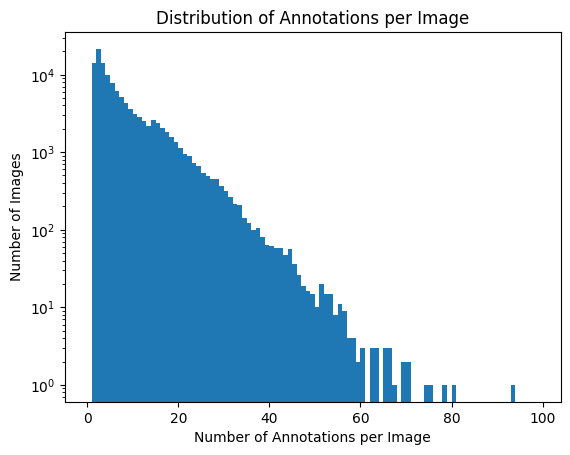

In [20]:
# plot annotation_counts_per_image
# plot hist of annotation_counts_per_image.values()
# bins 0 to 100
bins = np.arange(0, 100, 1)

plt.hist(list(annotation_counts_per_image.values()), bins = bins)#, bins=np.arange(1, 20), log=True)
plt.xlabel('Number of Annotations per Image')
plt.ylabel('Number of Images')
plt.title('Distribution of Annotations per Image')
plt.yscale('log')
plt.show()

## Construct single-class labels associated with the most common annotation for each image 

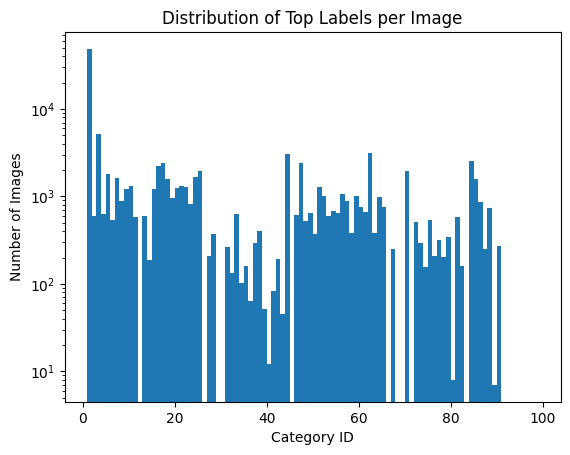

In [21]:
# create labels for each image, which is the category of the most common annotation, tie breaking should be the first annotation (sorted)

# sort lists of category_id
for k,v in image_id_to_category.items():
    image_id_to_category[k] = sorted(v)
# sort image_id_to_category keys
image_id_to_category = dict(sorted(image_id_to_category.items(), key=lambda item: item[0]))
image_id_to_category
# create labels for each image, which is the category of the most common annotation, tie breaking should be the first annotation (sorted)
image_id_to_top_label = {}

for k,v in image_id_to_category.items():
    # get the most common category
    from collections import Counter
    most_common = Counter(v).most_common(1)
    # get the category id
    if len(most_common) == 0:
        print(f"Image ID {k} has no annotations.")
        continue
    image_id_to_top_label[k] = most_common[0][0]
image_id_to_top_label 
# plot image_id_to_top_label histogram of labels
plt.hist(list(image_id_to_top_label.values()), bins=np.arange(1, 100), log=True)
plt.xlabel('Category ID')
plt.ylabel('Number of Images')
plt.title('Distribution of Top Labels per Image')
plt.yscale('log')
plt.show()

## Get a sense of what the top labels are going to look like

Category ID: 1, person
image id : 36; shape -- torch.Size([3, 256, 256])
other categories:
	person (1)
	umbrella (28)
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000036.jpg


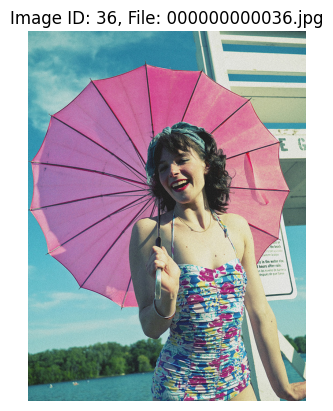

Category ID: 2, bicycle
image id : 775; shape -- torch.Size([3, 256, 256])
other categories:
	bicycle (2)
	car (3)
	motorcycle (4)
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000775.jpg


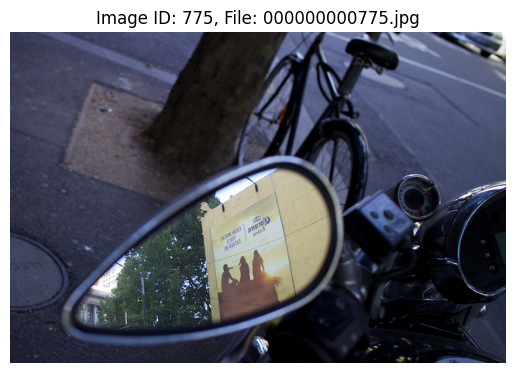

Category ID: 3, car
image id : 64; shape -- torch.Size([3, 256, 256])
other categories:
	car (3)
	truck (8)
	stop sign (13)
	clock (85)
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000064.jpg


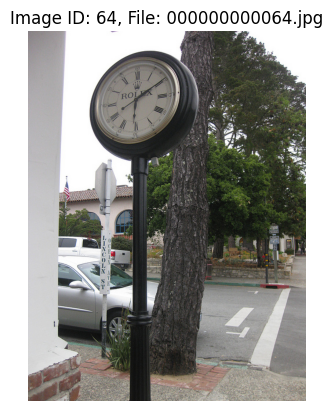

Category ID: 4, motorcycle
image id : 73; shape -- torch.Size([3, 256, 256])
other categories:
	motorcycle (4)
	motorcycle (4)
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000073.jpg


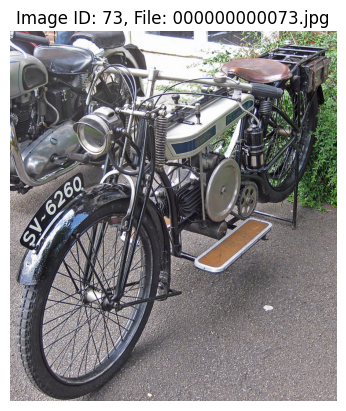

Category ID: 5, airplane
image id : 81; shape -- torch.Size([3, 256, 256])
other categories:
	airplane (5)
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000081.jpg


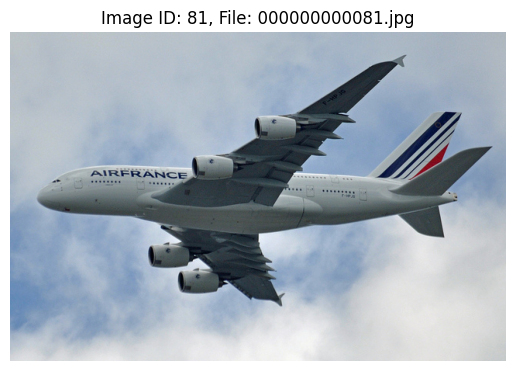

Category ID: 6, bus
image id : 681; shape -- torch.Size([3, 256, 256])
other categories:
	bus (6)
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000681.jpg


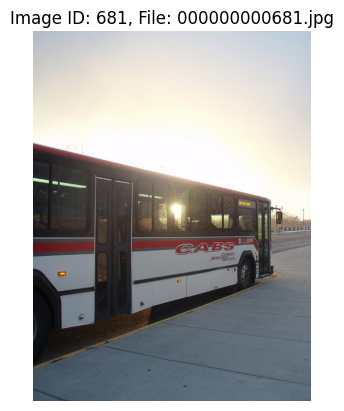

Category ID: 7, train
image id : 1090; shape -- torch.Size([3, 256, 256])
other categories:
	train (7)
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000001090.jpg


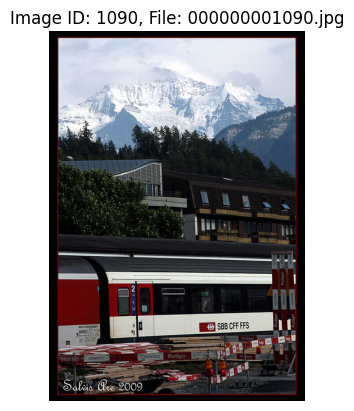

Category ID: 8, truck
image id : 1590; shape -- torch.Size([3, 256, 256])
other categories:
	truck (8)
	cow (21)
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000001590.jpg


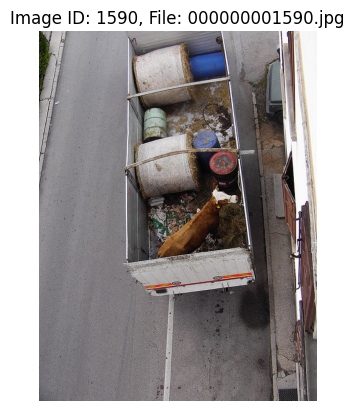

Category ID: 9, boat
image id : 400; shape -- torch.Size([3, 256, 256])
other categories:
	boat (9)
	dog (18)
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000400.jpg


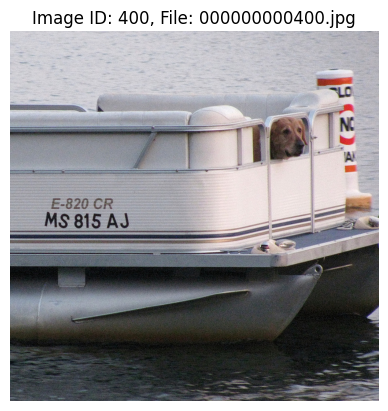

In [22]:
# show me an image with the top label = 1

label_ = 3
for label_ in range(1,10):
    # get the image id
    # print thename of hte category
    cat_name = category_id_to_name.get(label_, "Unknown")
    # get rest of categories
    print(f"Category ID: {label_}, {cat_name}")
    
    image_id = [k for k,v in image_id_to_top_label.items() if v == label_][0]
    # show the image
    print(f"image id : {image_id}; shape -- {train_dataset[image_id][0].shape}")
    other_categories = image_id_to_category[image_id]
    print(f"other categories:")
    for cat in other_categories:
        cat_name = category_id_to_name.get(cat, "Unknown")
        print(f"\t{cat_name} ({cat})")
    # print(f"Other categories: {other_categories}")
    show_image_from_id(image_id)

    

# train a Neural Net

In [23]:
image_id_to_top_label[9]

55

In [24]:
ids = sorted(list(image_id_to_top_label.keys()))
print(ids[:10])

print(len(image_id_to_top_label))

[9, 25, 30, 34, 36, 42, 49, 61, 64, 71]
117266


image_id-61
label - 0, category - person
image shape torch.Size([3, 256, 256])


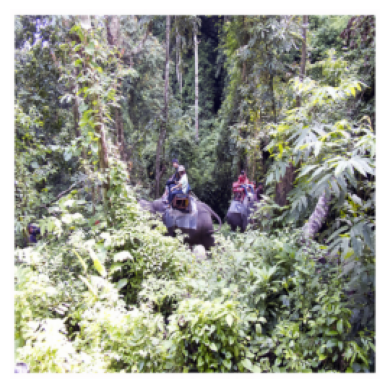

loading image from coco_data directly
loading image path : /n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000061.jpg


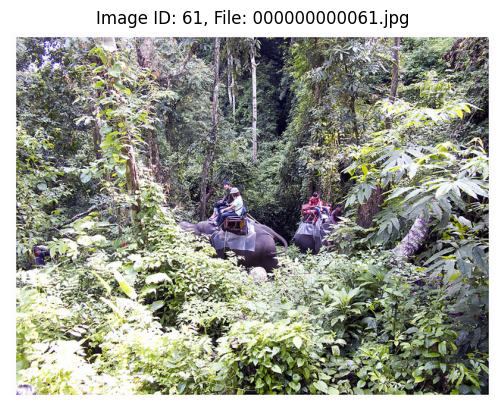

In [25]:
img_ind = 7 # index of image in dataset

image_path = train_dataset.image_paths[img_ind] 
image_id = get_image_num(image_path)

print(f"image_id-{image_id}")


image, label = train_dataset[img_ind]

#print(f"label - {label}, category - {category_id_to_name.get(label, 'Unknown')}")
print(f"label - {label}, category - {train_dataset.label_to_category_name.get(label, 'Unknown')}")


print(f"image shape {image.shape}")

show_image_from_tensor(image) # loads from coco_dataset_single_class


print(f"loading image from coco_data directly")
show_image_from_id(image_id) # loads from coco_data



In [26]:
train_dataset.image_paths

[PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000009.jpg'),
 PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000025.jpg'),
 PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000030.jpg'),
 PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000034.jpg'),
 PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000036.jpg'),
 PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000042.jpg'),
 PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000049.jpg'),
 PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000061.jpg'),
 PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco_download/train2017/000000000064.jpg'),
 PosixPath('/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/coco

In [28]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50
#from pycocotools.coco import COCO





In [ ]:

#  
# 
NUM_CLASSES = len(categories)

if False:
    
    # Configurations
    BATCH_SIZE = 128
    NUM_EPOCHS = 20
    LR = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"DEVICE  -- {DEVICE}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Model (ResNet50 as Backbone)
    model = resnet50(pretrained=False)
    model.fc = nn.Linear(2048, NUM_CLASSES)  # Adjust final layer for COCO classes
    #model = model.to(DEVICE)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    #
    model
    model= model.to(DEVICE)
elif False :
    # Configurations
    BATCH_SIZE = 256  # Reduce if running out of VRAM
    NUM_EPOCHS = 25  # More epochs for better convergence
    LR = 3e-4  # Faster convergence than 1e-4
    WEIGHT_DECAY = 1e-4  # Regularization to prevent overfitting
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    LR_SCHEDULER_STEP = 10  # Reduce LR after this many epochs
    LR_SCHEDULER_GAMMA = 0.5  # Reduce LR by this factor

    print(f"DEVICE  -- {DEVICE}")

    # Model (ResNet50 as Backbone)
    model = resnet50(pretrained=False)  # Start with a pretrained model for better convergence
    model.fc = nn.Linear(2048, NUM_CLASSES)  # Adjust final layer for COCO classes
    model = model.to(DEVICE)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)  # AdamW is better for large-scale classification

    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_SCHEDULER_STEP, gamma=LR_SCHEDULER_GAMMA)

    # Train & Validation Loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
else:
    # Configurations
    BATCH_SIZE = 128  # Reduce if VRAM runs out
    NUM_EPOCHS = 50  # Need more epochs since we're training from scratch
    LR = 1e-3  # Higher initial learning rate for faster convergence
    WEIGHT_DECAY = 1e-4  # Regularization
    MOMENTUM = 0.9  # Helps with convergence in SGD
    LR_SCHEDULER_STEP = 20  # Step down LR every 20 epochs
    LR_SCHEDULER_GAMMA = 0.1  # Reduce LR by factor of 10
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"DEVICE  -- {DEVICE}")

    # Model (ResNet50 from Scratch)
    model = resnet50(pretrained=False)  # No pretraining
    model.fc = nn.Linear(2048, NUM_CLASSES)  # Adjust final layer
    model = model.to(DEVICE)

    # Data Augmentation (Essential for Scratch Training)
    from torchvision import transforms
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)



# Validation Loop
def validate():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            labels = labels - 1  # 1 indexed to 0 indexed
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Run Training
verbose = False 

model.train()
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    model.train()
    for batch_i, (images, labels) in enumerate(train_loader):
        #labels = labels_ - 1  # 1 indexed to 0 indexed
        if verbose:
            print(f"labels-- {labels}")

        assert (labels >= 0).all() and (labels < 100).all(), f"Invalid label detected: {labels}"
        if verbose:
            print(f"types: {type(images)}, {type(labels)}")
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        # check if -1 in labels
        if verbose:
            print(f"sum - {torch.sum(labels == -1)}")
            print(f"labels-- {labels}")
            # devices
            print(f"images device -- {images.device}")
            print(f"labels device -- {labels.device}")
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        if verbose:
            print(f"loss device -- {loss.device}")
            print(loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_i % 10 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch: {batch_i} / {len(train_loader)}, Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")
    validate()

DEVICE  -- cuda
Epoch [1/25], Batch: 0 / 459, Loss: 4.5522


In [23]:
labels.device
outputs.device

device(type='cuda', index=0)

In [ ]:

# Transformations
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load COCO Dataset
class CocoSingleLabel(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transform=None):
        super().__init__(img_folder, ann_file, transform)
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgToAnns.keys())

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        labels = [ann["category_id"] for ann in target]
        if len(labels) == 0:
            return None  # Ignore images with no labels
        label = labels[0]  # Select only the first label per image
        return img, label

# Paths (Modify as needed)
train_img_folder = "/path/to/coco/train2017"
train_ann_file = "/path/to/coco/annotations/instances_train2017.json"
val_img_folder = "/path/to/coco/val2017"
val_ann_file = "/path/to/coco/annotations/instances_val2017.json"

# Datasets and DataLoaders
train_dataset = CocoSingleLabel(train_img_folder, train_ann_file, transform=transform)
val_dataset = CocoSingleLabel(val_img_folder, val_ann_file, transform=transform)

# Remove None values from dataset
train_dataset = [x for x in train_dataset if x is not None]
val_dataset = [x for x in val_dataset if x is not None]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
